# Makespan policies

In this notebook, we compare various heterogeneity-agnostic and heterogeneity-aware makespan policies, with and without space sharing.

## Import statements

In [1]:
from plotting_utils import *
from utils import get_logfile_paths, makespan_fn, prune

## Get list of relevant logfiles and define label mapping

In [2]:
logfile_paths = sorted(
    get_logfile_paths(
        "/future/u/deepakn/gavel/logs/cluster_sweep_static_jobs_final/", static_trace=True))

## Plotting functions

In [3]:
def plot_metric_vs_num_total_jobs(logfile_paths,
                                  clusters, metric_fn,
                                  metric_label, xmax=None, ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"resource_fraction": [], "metric": [], "seed": []}
    for (v100s, k80s) in clusters:
        p100s = 0
        metrics = {}
        for policy in ["min_total_duration", "min_total_duration_perf"]:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy)))
            metrics[policy] = {
                x[2]: metric_fn(x[1])
                for x in relevant_logfile_paths}
            seeds = sorted(list(metrics[policy].keys()))

        metrics_to_plot = [metrics["min_total_duration"][seed] / metrics["min_total_duration_perf"][seed]
                           for seed in seeds]
        import pandas as pd
        data["resource_fraction"] += [float(v100s) / (float(v100s) + float(k80s))
                                     for seed in seeds]
        data["metric"] += metrics_to_plot
        data["seed"] += seeds
    import pandas as pd
    df = pd.DataFrame(data)
    print(df.groupby(["resource_fraction", "seed"]).mean())

    sns.lineplot(x='resource_fraction', y='metric',
                 data=data, ci='sd',
                 markers=True, marker='o')

    ax.set_xlabel("Fraction of V100s")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0.05, 1.05])
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    leg = plt.legend(frameon=False)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    bb.y0 += 0.22
    bb.y1 += 0.22
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

## Plot makespan vs. number of jobs

No handles with labels found to put in legend.


                          metric
resource_fraction seed          
0.1               0     1.399128
                  1     1.533341
                  2     1.373464
0.2               0     1.499276
                  1     1.588435
                  2     1.377788
0.3               0     1.578346
                  1     1.592421
                  2     1.370682
0.4               0     1.604264
                  1     1.524533
                  2     1.353002
0.5               0     1.666300
                  1     1.330557
                  2     1.357304
0.6               0     1.673249
                  1     1.224292
                  2     1.372397
0.7               0     1.491450
                  1     1.088060
                  2     1.322424
0.8               0     1.356331
                  1     1.074051
                  2     1.229077
0.9               0     1.237316
                  1     1.057099
                  2     1.136827
1.0               0     1.000000
          

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


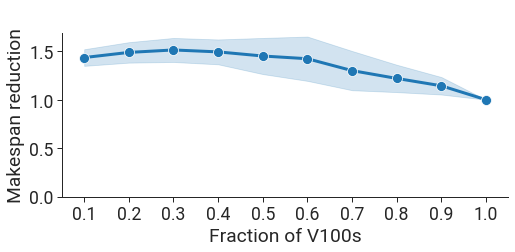

In [4]:
plot_metric_vs_num_total_jobs(
    logfile_paths,
    clusters=[(100, 0), (90, 10), (80, 20), (70, 30), (60, 40),
              (50, 50), (40, 60), (30, 70), (20, 80), (10, 90)],
    metric_fn=makespan_fn,
    metric_label="Makespan reduction",
    xmax=None,
    ymax=None,
    output_filename="cluster_sweep/makespan.pdf"
)